# Uncertainty implementation

In [60]:
import pandas as pd

# 1. Load the CFs from the new Excel file directly
cf_data = pd.read_excel("AWARE20_Native_CFs.xlsx", sheet_name="native_CFs")

# Keep only what's needed
cf_data = cf_data.loc[:, [
    "Basin_ID",
    "annual_unspecified", "annual_agri", "annual_nonagri"
]]

# 2. Load water consumption data for each type
agri = pd.read_excel("AWARE20_pHWC_agri_country_cons_per_basin_consolidated.xlsx")
agri = agri.loc[:, ["ecoinvent_shortname", "Basin_ID", "annual"]]

non_agri = pd.read_excel("AWARE20_pHWC_nonagri_country_cons_per_basin_consolidated.xlsx")
non_agri = non_agri.loc[:, ["ecoinvent_shortname", "Basin_ID", "annual"]]

unspecified = pd.read_excel("AWARE20_pHWC_all_country_cons_per_basin_consolidated.xlsx")
unspecified = unspecified.loc[:, ["ecoinvent_shortname", "Basin_ID", "annual"]]

# 3. Rename annual columns to reflect their types
agri = agri.rename(columns={"annual": "annual_agri"})
non_agri = non_agri.rename(columns={"annual": "annual_nonagri"})
unspecified = unspecified.rename(columns={"annual": "annual_unspecified"})

# 4. Merge all consumption types into one dataframe
df_combined = pd.merge(unspecified, agri, on=["Basin_ID", "ecoinvent_shortname"], how="outer")
df_combined = pd.merge(df_combined, non_agri, on=["Basin_ID", "ecoinvent_shortname"], how="outer")

# 5. Merge with the CFs (based on Basin_ID)
df_final = pd.merge(df_combined, cf_data, on="Basin_ID", how="left")
df_final.columns = [
    'ecoinvent_shortname',
    'Basin_ID',
    'annual_unspecified',
    'annual_agri',
    'annual_nonagri',
    'CF_annual_unspecified',
    'CF_annual_agri',
    'CF_annual_nonagri'
]


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings

# Initialize results list
results = []

# Unified dataframe with CFs and annual water consumption
df = df_final  # Replace with your actual unified DataFrame

# Water use types to process
consumption_types = ["unspecified", "agri", "nonagri"]

for water_type in consumption_types:
    print(f"Processing water type: {water_type}")
    cf_col = f"CF_annual_{water_type}"
    wt_col = f"annual_{water_type}"

    countries = df['ecoinvent_shortname'].dropna().unique()
    print("Number of countries:", len(countries))

    for c, country in enumerate(countries):
        print(f"  {c+1}/{len(countries)}: {country}")
        subset = df[
            (df['ecoinvent_shortname'] == country) &
            (df[cf_col].notnull()) &
            (df[wt_col].notnull()) &
            (df[wt_col] > 0)
        ]

        if subset.empty:
            continue

        values = subset[cf_col]
        weights = subset[wt_col]
        n_basins = len(subset)

        if n_basins <= 1:
            continue

        # Expand the data by normalized weights
        weights_normalized = (weights / weights.max() * 100).astype(int)
        expanded_values = np.repeat(values, weights_normalized)

        support_values = None
        support_weights = None

        # Fallback for small sample
        if n_basins < 10:
            values_array = values.to_numpy()
            weights_array = weights.to_numpy()
            unique_cfs, inv_idx = np.unique(values_array, return_inverse=True)
            weighted_counts = np.zeros_like(unique_cfs, dtype=float)
            np.add.at(weighted_counts, inv_idx, weights_array)
            probs = weighted_counts / weighted_counts.sum()

            chosen_dist = "discrete_empirical"
            chosen_params = None
            best_sse = np.nan
            support_values = unique_cfs.tolist()
            support_weights = probs.tolist()
        else:
            distributions = {
                "norm": stats.norm,
                "lognorm": stats.lognorm,
                "gamma": stats.gamma,
                "beta": stats.beta,
                "weibull_min": stats.weibull_min,
                "triang": stats.triang,
            }

            best_fit = None
            best_name = None
            best_sse = np.inf
            x = np.linspace(values.min(), values.max(), 100)

            for name, dist in distributions.items():
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=RuntimeWarning)
                        params = dist.fit(expanded_values)

                    # SSE computation
                    hist_counts, bin_edges = np.histogram(expanded_values, bins=30, density=True)
                    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
                    pdf_at_bins = dist.pdf(bin_centers, *params)
                    sse = np.sum((hist_counts - pdf_at_bins)**2)

                    if sse < best_sse:
                        best_sse = sse
                        best_fit = (name, params)
                        best_name = name
                except Exception:
                    continue

            # SSE threshold decision
            sse_threshold = 0.02 if n_basins > 100 else 0.05 if n_basins > 30 else 0.08

            if best_fit and best_sse <= sse_threshold:
                chosen_dist = best_name
                chosen_params = best_fit[1]
            else:
                chosen_dist = "uniform"
                chosen_params = (expanded_values.min(), expanded_values.max())
                best_sse = np.nan

        # Compute weighted mean
        mean_cf = np.average(values, weights=weights)

        # Build parameter dictionary
        param_dict = {
            "country": country,
            "type": water_type,
            "n_basins": n_basins,
            "distribution": chosen_dist,
            "mean_CF": mean_cf,
            "shape_a": None,
            "shape_b": None,
            "loc": None,
            "scale": None,
            "minimum": None,
            "maximum": None,
            "fit_score_sse": best_sse,
            "values": support_values,
            "weights": support_weights
        }

        # Handle each distribution type
        if chosen_dist == "uniform":
            param_dict["minimum"], param_dict["maximum"] = chosen_params
        elif chosen_dist == "discrete_empirical":
            pass  # already handled above
        elif chosen_dist == "triang":
            c, loc_raw, scale = chosen_params
            mode = loc_raw + c * scale
            min_val = loc_raw
            max_val = loc_raw + scale

            param_dict["loc"] = mode
            param_dict["minimum"] = min(values)
            param_dict["maximum"] = max(values)
        elif chosen_dist == "beta":
            param_dict["shape_a"], param_dict["shape_b"], param_dict["loc"], param_dict["scale"] = chosen_params
            param_dict["minimum"] = 0.1
            param_dict["maximum"] = 100
        elif chosen_dist in ["lognorm", "weibull_min", "gamma"]:
            param_dict["shape_a"], param_dict["loc"], param_dict["scale"] = chosen_params
            param_dict["minimum"] = 0.1
            param_dict["maximum"] = 100
        else:  # norm
            param_dict["loc"], param_dict["scale"] = chosen_params
            param_dict["minimum"] = 0.1
            param_dict["maximum"] = 100

        results.append(param_dict)

# Create DataFrame
results_df = pd.DataFrame(results)

# Reorder columns
results_df = results_df[[
    "country", "type", "n_basins", "distribution",
    "shape_a", "shape_b", "loc", "scale", "minimum", "maximum", "mean_CF",
    "fit_score_sse", "values", "weights"
]]

# Save
results_df.to_csv("distribution_summary_per_country_per_type.csv", index=False)
print("✅ Distribution summary exported.")


Processing water type: unspecified
Number of countries: 530
  1/530: DK
  2/530: GL
  3/530: RNA
  4/530: UN-AMERICAS
  5/530: CA
  6/530: CA-NU
  7/530: CUSMA/T-MEC/USMCA
  8/530: Canada without Alberta
  9/530: Canada without Alberta and Quebec
  10/530: Canada without Quebec
  11/530: IAI Area, North America
  12/530: IAI Area, North America, without Quebec
  13/530: NAFTA
  14/530: North America without Quebec
  15/530: ENTSO-E
  16/530: Europe without Austria
  17/530: Europe without NORDEL (NCPA)
  18/530: Europe without Switzerland
  19/530: Europe without Switzerland and Austria
  20/530: Europe without Switzerland and France
  21/530: Europe, without Russia and Türkiye
  22/530: NO
  23/530: RER
  24/530: RER w/o AT+BE+CH+DE+FR+IT
  25/530: RER w/o CH+DE
  26/530: RER w/o DE+NL+NO
  27/530: RER w/o DE+NL+NO+RU
  28/530: RER w/o DE+NL+RU
  29/530: RER w/o RU
  30/530: SJ
  31/530: UN-EUROPE
  32/530: UN-NEUROPE
  33/530: Asia without China
  34/530: FSU
  35/530: IAI Area, Russ

/opt/homebrew/Caskroom/miniforge/base/envs/bw2/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:1988: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


  485/530: BR-PR
  486/530: BR-Southern grid
  487/530: ZA
  488/530: BR-SC
  489/530: SZ
  490/530: AU-NSW
  491/530: LS
  492/530: BR-RS
  493/530: UY
  494/530: AU-ACT
  495/530: AU-VIC
  496/530: NZ
  497/530: AU-JBT
  498/530: AU-TAS
  499/530: FK
  500/530: UM
  501/530: GS
  502/530: HM
  503/530: SC
  504/530: FM
  505/530: PF
  506/530: MH
  507/530: UN-MICRONESIA
  508/530: IN-LD
  509/530: TF
  510/530: CK
  511/530: PN
  512/530: MV
  513/530: TV
  514/530: MP
  515/530: AU-IOT
  516/530: CC
  517/530: WF
  518/530: SH
  519/530: KI
  520/530: NR
  521/530: CX
  522/530: PW
  523/530: Coral Sea Islands
  524/530: NF
  525/530: TK
  526/530: GU
  527/530: BM
  528/530: NU
  529/530: KY
  530/530: IO
Processing water type: nonagri
Number of countries: 530
  1/530: DK
  2/530: GL
  3/530: RNA
  4/530: UN-AMERICAS
  5/530: CA
  6/530: CA-NU
  7/530: CUSMA/T-MEC/USMCA
  8/530: Canada without Alberta
  9/530: Canada without Alberta and Quebec
  10/530: Canada without Quebec
  11/

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

def plot_country_distribution(df_data, df_fit, country, water_type):
    """
    Plot a weighted histogram and fitted distribution for a given country and water type.

    Parameters:
        df_data: unified dataframe with 'CF_annual_*' and 'annual_*' columns
        df_fit: results dataframe with fit parameters
        country: ISO country code (e.g., "CH")
        water_type: one of ["unspecified", "agri", "nonagri"]
    """
    cf_col = f"CF_annual_{water_type}"
    wt_col = f"annual_{water_type}"

    # Subset the data
    subset = df_data[
        (df_data['ecoinvent_shortname'] == country) &
        (df_data[cf_col].notnull()) &
        (df_data[wt_col].notnull()) &
        (df_data[wt_col] > 0)
    ]
    if subset.empty:
        print(f"No data found for {country} and {water_type}")
        return

    values = subset[cf_col]
    weights = subset[wt_col]

    # Get fitted parameters
    row = df_fit[(df_fit['country'] == country) & (df_fit['type'] == water_type)]
    if row.empty:
        print(f"No fit found for {country} and {water_type}")
        return
    row = row.iloc[0]

    dist_name = row["distribution"]
    shape = row["shape_a"]
    loc = row["loc"]
    scale = row["scale"]
    minimum = row["minimum"]
    maximum = row["maximum"]
    mean_cf = row["mean_CF"]
    n = row["n_basins"]

    # Start figure
    plt.figure(figsize=(4, 3))

    # Histogram
    hist_counts, bin_edges, _ = plt.hist(
        values, bins=30, weights=weights, density=True,
        alpha=0.6, edgecolor='black', label="Weighted histogram"
    )

    # Fitted distribution
    x = np.linspace(values.min(), values.max(), 200)

    if dist_name == "uniform":
        if maximum > minimum:
            pdf = np.ones_like(x) / (maximum - minimum)
            pdf[(x < minimum) | (x > maximum)] = 0
            # Uniform fits are already on same scale
            plt.plot(x, pdf, 'r--', label="Uniform fit")
    else:
        try:
            dist = getattr(stats, dist_name)
            if dist_name in ["lognorm", "weibull_min", "triang"]:
                pdf = dist.pdf(x, shape, loc, scale)
            elif dist_name == "gamma":
                pdf = dist.pdf(x, shape, loc, scale)
            elif dist_name == "beta":
                pdf = np.zeros_like(x)  # incomplete parameter info
            else:  # norm
                pdf = dist.pdf(x, loc, scale)
                print(shape, loc, scale)

            # Rescale PDF to histogram height
            if pdf.max() > 0:
                pdf_scaled = pdf * (hist_counts.max() / pdf.max())
                plt.plot(x, pdf_scaled, 'r-', label=f"{dist_name} fit")
        except Exception:
            pass

    # Annotate
    plt.title(f"{country} – {water_type} water\nn = {n}, mean CF = {mean_cf:.2f}")
    plt.xlabel("Basin CF")
    plt.ylabel("Density (weighted)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("/Users/romain/Library/CloudStorage/OneDrive-PaulScherrerInstitut/edges/scripts/figure_2.png")
    plt.show()


nan 74.16988165680473 13.23185925689504


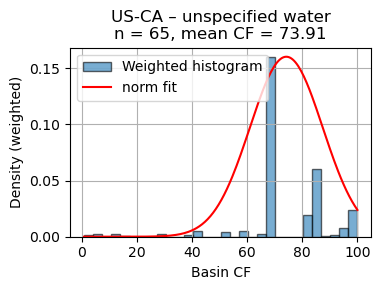

In [23]:
results_df = pd.read_csv("distribution_summary_per_country_per_type.csv")
plot_country_distribution(
    df_final,
    results_df,
    country="US-CA",
    water_type="unspecified"
)


In [55]:
results_df = pd.read_csv("distribution_summary_per_country_per_type.csv")
results_df = results_df.loc[results_df["type"]=="agri"]
original_CFs = pd.read_excel("AWARE20_Countries_and_Regions.xlsx", sheet_name="CFs_agri")
original_CFs = original_CFs[["ecoinvent_shortname", "Annual"]]
original_CFs = original_CFs.loc[original_CFs["Annual"]!="NotDefined"]
results_df = results_df.merge(right=original_CFs, right_on="ecoinvent_shortname", left_on="country")

In [56]:
import pandas as pd
import numpy as np
import ast

# Step 1: Filter for discrete_empirical and drop missing
mask = (results_df["distribution"] == "discrete_empirical")
valid_rows = results_df[mask & results_df["values"].notnull() & results_df["Annual"].notnull()].copy()

# Step 2: Convert 'values' from string to list if needed
valid_rows["values"] = valid_rows["values"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Step 3: Compute min/max from values
valid_rows["min_val"] = valid_rows["values"].apply(lambda x: min(x) if isinstance(x, list) and x else np.nan)
valid_rows["max_val"] = valid_rows["values"].apply(lambda x: max(x) if isinstance(x, list) and x else np.nan)

# Step 4: Identify where mean_CF is outside of value range
outside_range = (valid_rows["Annual"] < valid_rows["min_val"]) | (valid_rows["Annual"] > valid_rows["max_val"])
result = valid_rows[outside_range]


In [57]:
"IN-SK" in result["country"]

False

In [59]:
result.to_excel("uncertainty_to_exclude.xlsx")

In [37]:
results_df.loc[results_df["country"] == "IN-SK"]

,country,type,n_basins,distribution,shape_a,shape_b,loc,scale,minimum,maximum,mean_CF,fit_score_sse,values,weights
300,IN-SK,unspecified,2,discrete_empirical,NaN,NaN,NaN,NaN,NaN,NaN,4.603630,NaN,"[4.5, 36.6]","[0.9967716552257871, 0.0032283447742128576]"
800,IN-SK,agri,2,discrete_empirical,NaN,NaN,NaN,NaN,NaN,NaN,4.538066,NaN,"[4.49, 34.3]","[0.9983876046688127, 0.0016123953311873477]"
1283,IN-SK,nonagri,2,discrete_empirical,NaN,NaN,NaN,NaN,NaN,NaN,4.744965,NaN,"[4.58, 51.1]","[0.9964538881853013, 0.0035461118146986074]"


,country,type,n_basins,distribution,shape_a,shape_b,loc,scale,minimum,maximum,mean_CF,fit_score_sse,values,weights,ecoinvent_shortname,Annual
0,DK,unspecified,49,uniform,NaN,NaN,NaN,NaN,1.220,4.21,2.451327,NaN,NaN,NaN,DK,2.7
1,RNA,unspecified,1122,gamma,0.456929,NaN,0.248000,57.025276,0.100,100.00,32.694571,0.006080,NaN,NaN,RNA,36.6
2,UN-AMERICAS,unspecified,2314,lognorm,2.101654,NaN,0.211045,7.989036,0.100,100.00,30.810018,0.002806,NaN,NaN,UN-AMERICAS,35.8
3,CA,unspecified,482,uniform,NaN,NaN,NaN,NaN,0.927,91.90,7.003239,NaN,NaN,NaN,CA,9.65
4,CA-NU,unspecified,60,lognorm,1.385380,NaN,2.301735,3.221281,0.100,100.00,10.335815,0.008777,NaN,NaN,CA-NU,NotDefined
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,PW,nonagri,2,discrete_empirical,NaN,NaN,NaN,NaN,NaN,NaN,0.547929,NaN,"[0.51, 0.589]","[0.5198886839138088, 0.4801113160861911]",PW,NotDefined
1486,GU,nonagri,2,discrete_empirical,NaN,NaN,NaN,NaN,NaN,NaN,2.769228,NaN,"[2.59, 3.11]","[0.6553314515038414, 0.34466854849615847]",GU,3.55
1487,BM,nonagri,1,discrete_empirical,NaN,NaN,NaN,NaN,NaN,NaN,3.020000,NaN,[3.02],[1.0],BM,NotDefined
1488,NU,nonagri,2,discrete_empirical,NaN,NaN,NaN,NaN,NaN,NaN,2.334794,NaN,"[2.26, 2.35]","[0.16895071057971442, 0.8310492894202856]",NU,NotDefined


In [19]:
# Source DataFrame: one row per (country, water type)
df = results_df  # replace if needed

# Initialize the output dictionary
country_distributions = {}

for _, row in df.iterrows():
    country = row["country"]
    water_type = row["type"]
    dist = row["distribution"]

    # Gather the parameters depending on distribution type
    if dist == "uniform":
        params = {
            "minimum": row["minimum"],
            "maximum": row["maximum"]
        }
    elif dist == "discrete_empirical":
        params = {
            "support_values": row["support_values"],
            "support_weights": row["support_weights"]
        }
    else:
        # Continuous distributions
        params = {
            "shape": row["shape"],
            "loc": row["loc"],
            "scale": row["scale"],
            "minimum": row["minimum"],
            "maximum": row["maximum"]
        }

    # Create inner dict
    entry = {
        "distribution": dist,
        "parameters": params
    }

    # Store under country → type → entry
    if country not in country_distributions:
        country_distributions[country] = {}
    country_distributions[country][water_type] = entry


KeyError: 'shape'

In [91]:
country_distributions["FR"]

{'unspecified': {'distribution': 'beta',
  'parameters': {'shape': 0.996773831391983,
   'loc': -9.64795825450652,
   'scale': 109.64795825450653,
   'min': nan,
   'max': nan}},
 'agri': {'distribution': 'triang',
  'parameters': {'shape': nan,
   'loc': 100.00000584467686,
   'scale': nan,
   'min': 0.548,
   'max': 100.0}},
 'nonagri': {'distribution': 'weibull_min',
  'parameters': {'shape': 0.5894435011368635,
   'loc': 0.6249999999999999,
   'scale': 62.67077699730068,
   'min': nan,
   'max': nan}}}